## Forward-backward splitting for time-varying graphical lasso
This notebook shows how to minimise the time-varying graphical lasso with element-wise penalty norms across time-points.

First of all, as always, let's create a bunch of data.
For this task, we generate eah variable to change according to a certain behaviour which can be described as evolution via tigonometric functions, such as `sin` and `cos`.

In [279]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from regain.datasets import is_pos_def
reload(datasets);

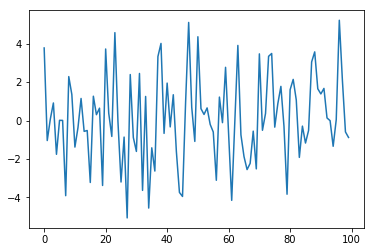

In [275]:
np.random.seed(7)

fs = 10e3
N = 100
amp = 2*np.sqrt(2)
freq = 1.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
z = amp*np.sin(2*np.pi*freq*time)
z += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
plt.plot(z);

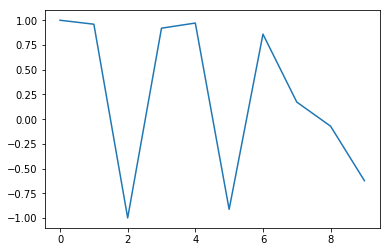

In [276]:
from scipy import signal
sig = signal.sweep_poly(np.arange(10), np.arange(20))
plt.plot(sig);

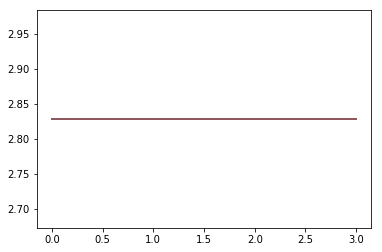

In [277]:
T = 4

x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
zz = amp * signal.square(2 * np.pi * freq * x + phase, duty=.5)
plt.plot(x.T, zz.T);

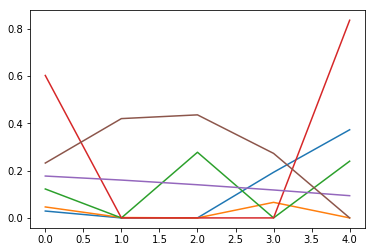

In [278]:
np.random.seed(7)
n_samples = 10
n_dim_obs = 4
n_dim_lat = 0  # we want to use the TGL, without latent variables
T = 5

upper_idx = np.triu_indices(n_dim_obs, 1)
n_interactions = len(upper_idx[0])

x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
phase = np.random.rand(n_interactions, 1)
freq = np.random.rand(n_interactions, 1) - .70
A = np.random.rand(n_interactions, 1)
y = A * np.sin(2. * np.pi * freq * x + phase)

# threshold
y = np.maximum(y, 0)

plt.plot(x.T, y.T);

In [9]:
Y = np.array([squareform(y[:, j]) + np.eye(n_dim_obs) for j in range(y.shape[1])])
assert all(is_pos_def(_) for _ in Y)

In [280]:
from sklearn.gaussian_process import kernels
ker = np.array([kernels.RBF(length_scale=.2)(y[:, j][:, None]) for j in range(y.shape[1])])

In [281]:
from regain import datasets; reload(datasets);

n_samples = 10
n_dim_obs = 4
n_dim_lat = 0  # we want to use the TGL, without latent variables
T = 3

data = datasets.make_dataset(
     mode='sin', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=n_dim_obs, T=T)

AssertionError: 

Generate the data starting from the inverse covariance matrices.

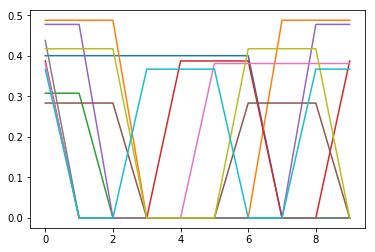

In [342]:
np.random.seed(7)

n_samples = 1000
n_dim_obs = 5
T = 10

def make_sin(n_dim_obs, n_dim_lat, T, shape='smooth', closeness=1):
    upper_idx = np.triu_indices(n_dim_obs, 1)
    n_interactions = len(upper_idx[0])
    x = np.tile(np.linspace(0, (T-1.) / closeness, T), (n_interactions, 1))
    phase = np.random.rand(n_interactions, 1)
    freq = np.random.rand(n_interactions, 1) - .50
    A = (np.random.rand(n_interactions, 1) + 1) / 2.
    
    if shape == 'smooth':
        y = A * np.sin(2. * np.pi * freq * x + phase)
    else:
        y = A * signal.square(2 * np.pi * freq * x + phase, duty=.5)

    # threshold
    y = np.maximum(y, 0)

    Y = np.array([squareform(y[:, j]) + 2 * np.eye(n_dim_obs) for j in range(y.shape[1])]) / 2.

    assert all(is_pos_def(_) for _ in Y)
    return Y, Y, np.zeros_like(Y)

data = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode=make_sin, shape='square', closeness=2.4)

plt.plot(np.array([squareform(y, checks=None) for y in data.thetas]), '-');

## Let's run 

In [343]:
from sklearn.model_selection import train_test_split
X = data.data
X_tr, X_ts = train_test_split(X)

In [287]:
from regain import norm; reload(norm);
from regain.forward_backward import time_graph_lasso_; reload(time_graph_lasso_)

tglfb = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, gamma=2, alpha=10, beta=1, time_norm=2, max_iter=500, time_on_axis='last').fit(X_tr)

In [288]:
utils.structure_error(data.thetas, tglfb.precision_, no_diagonal=0)

{'accuracy': 0.76,
 'balanced_accuracy': 0.7211181770005299,
 'dor': 14.351999999999999,
 'f1': 0.8214285714285715,
 'fall_out': 0.49019607843137253,
 'false_omission_rate': 0.16129032258064516,
 'fdr': 0.26595744680851063,
 'fn': 10,
 'fp': 50,
 'miss_rate': 0.06756756756756757,
 'nlr': 0.13253638253638256,
 'npv': 0.8387096774193549,
 'plr': 1.9021621621621623,
 'precision': 0.7340425531914894,
 'prevalence': 0.592,
 'recall': 0.9324324324324325,
 'specificity': 0.5098039215686274,
 'tn': 52,
 'tp': 138}

GridSearchCV for parameters

In [84]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# data_grid = np.array(data.data).transpose(1,2,0)
param_grid=dict(alpha=np.logspace(-2,0,3), beta=np.logspace(-2,0,3), gamma=np.logspace(-2, 0, 3),
               time_norm=[1, 2])

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.2)
ltgl = GridSearchCV(mdl, param_grid, cv=cv, verbose=1)
ltgl.fit(data_grid)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=2, random_state=None, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=TimeGraphLassoForwardBackward(alpha=0.01, assume_centered=False, beta=1.0,
               compute_objective=True, delta=0.0001, gamma=1.0,
               lamda_criterion='b', max_iter=100, time_norm=1,
               time_on_axis='last', tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.01, 0.1 , 1.  ]), 'beta': array([0.01, 0.1 , 1.  ]), 'time_norm': [1, 2], 'gamma': array([0.01, 0.1 , 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [344]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

In [345]:
import skopt; reload(skopt)
import skopt.searchcv; reload(skopt.searchcv)
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [346]:
reload(time_graph_lasso_)
data_grid = np.array(data.data)

domain = {'alpha': Real(1e-1, 1e2, prior='log-uniform'),
          'beta': Integer(1, 3)}

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, tol=1e-4, max_iter=400, gamma=1., beta=1, time_norm=2, time_on_axis='last')
    
cv = ShuffleSplit(3, test_size=0.2)
    
ltgl = BayesSearchCV(
    mdl, domain, n_iter=20, cv=cv, verbose=2)

ltgl.fit(data_grid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=36.519455416754816, beta=2 ................................
[CV] ................. alpha=36.519455416754816, beta=2, total=   5.6s
[CV] alpha=36.519455416754816, beta=2 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................. alpha=36.519455416754816, beta=2, total=   5.6s
[CV] alpha=36.519455416754816, beta=2 ................................
[CV] ................. alpha=36.519455416754816, beta=2, total=   5.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=43.19657378254807, beta=3 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


[CV] .................. alpha=43.19657378254807, beta=3, total=   5.7s
[CV] alpha=43.19657378254807, beta=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] .................. alpha=43.19657378254807, beta=3, total=   5.9s
[CV] alpha=43.19657378254807, beta=3 .................................
[CV] .................. alpha=43.19657378254807, beta=3, total=   5.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.2506056922950485, beta=2 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.2s finished


[CV] ................. alpha=0.2506056922950485, beta=2, total=   5.5s
[CV] alpha=0.2506056922950485, beta=2 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................. alpha=0.2506056922950485, beta=2, total=   5.7s
[CV] alpha=0.2506056922950485, beta=2 ................................
[CV] ................. alpha=0.2506056922950485, beta=2, total=   5.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=47.82646807587031, beta=1 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


[CV] .................. alpha=47.82646807587031, beta=1, total=   5.5s
[CV] alpha=47.82646807587031, beta=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] .................. alpha=47.82646807587031, beta=1, total=   5.5s
[CV] alpha=47.82646807587031, beta=1 .................................
[CV] .................. alpha=47.82646807587031, beta=1, total=   5.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.13157383519799537, beta=3 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.6s finished


[CV] ................ alpha=0.13157383519799537, beta=3, total=   5.6s
[CV] alpha=0.13157383519799537, beta=3 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................ alpha=0.13157383519799537, beta=3, total=   5.5s
[CV] alpha=0.13157383519799537, beta=3 ...............................
[CV] ................ alpha=0.13157383519799537, beta=3, total=   5.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.3001822743088263, beta=3 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


[CV] ................. alpha=0.3001822743088263, beta=3, total=   5.6s
[CV] alpha=0.3001822743088263, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................. alpha=0.3001822743088263, beta=3, total=   5.5s
[CV] alpha=0.3001822743088263, beta=3 ................................
[CV] ................. alpha=0.3001822743088263, beta=3, total=   5.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=1.393536523734452, beta=2 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


[CV] .................. alpha=1.393536523734452, beta=2, total=   5.5s
[CV] alpha=1.393536523734452, beta=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] .................. alpha=1.393536523734452, beta=2, total=   5.5s
[CV] alpha=1.393536523734452, beta=2 .................................
[CV] .................. alpha=1.393536523734452, beta=2, total=   5.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=1.722664398695986, beta=2 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.6s finished


[CV] .................. alpha=1.722664398695986, beta=2, total=   5.4s
[CV] alpha=1.722664398695986, beta=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] .................. alpha=1.722664398695986, beta=2, total=   5.5s
[CV] alpha=1.722664398695986, beta=2 .................................
[CV] .................. alpha=1.722664398695986, beta=2, total=   5.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=78.7672269343617, beta=2 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.6s finished


[CV] ................... alpha=78.7672269343617, beta=2, total=   5.7s
[CV] alpha=78.7672269343617, beta=2 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ................... alpha=78.7672269343617, beta=2, total=   5.5s
[CV] alpha=78.7672269343617, beta=2 ..................................
[CV] ................... alpha=78.7672269343617, beta=2, total=   7.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.3006309406116009, beta=3 ................................
[CV] ................. alpha=0.3006309406116009, beta=3, total=   5.7s
[CV] alpha=0.3006309406116009, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ................. alpha=0.3006309406116009, beta=3, total=   5.6s
[CV] alpha=0.3006309406116009, beta=3 ................................
[CV] ................. alpha=0.3006309406116009, beta=3, total=   9.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=79.01284484236903, beta=2 .................................
[CV] .................. alpha=79.01284484236903, beta=2, total=   5.6s
[CV] alpha=79.01284484236903, beta=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .................. alpha=79.01284484236903, beta=2, total=   5.5s
[CV] alpha=79.01284484236903, beta=2 .................................
[CV] .................. alpha=79.01284484236903, beta=2, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=1.3508745056023015, beta=3 ................................
[CV] ................. alpha=1.3508745056023015, beta=3, total=   5.6s
[CV] alpha=1.3508745056023015, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................. alpha=1.3508745056023015, beta=3, total=   5.8s
[CV] alpha=1.3508745056023015, beta=3 ................................
[CV] ................. alpha=1.3508745056023015, beta=3, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=79.03840503447671, beta=2 .................................
[CV] .................. alpha=79.03840503447671, beta=2, total=   5.5s
[CV] alpha=79.03840503447671, beta=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] .................. alpha=79.03840503447671, beta=2, total=   5.6s
[CV] alpha=79.03840503447671, beta=2 .................................
[CV] .................. alpha=79.03840503447671, beta=2, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.30116542405822017, beta=3 ...............................
[CV] ................ alpha=0.30116542405822017, beta=3, total=  12.1s
[CV] alpha=0.30116542405822017, beta=3 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV] ................ alpha=0.30116542405822017, beta=3, total=   5.7s
[CV] alpha=0.30116542405822017, beta=3 ...............................
[CV] ................ alpha=0.30116542405822017, beta=3, total=   5.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.3015871000695119, beta=3 ................................
[CV] ................. alpha=0.3015871000695119, beta=3, total=   5.7s
[CV] alpha=0.3015871000695119, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ................. alpha=0.3015871000695119, beta=3, total=   5.7s
[CV] alpha=0.3015871000695119, beta=3 ................................
[CV] ................. alpha=0.3015871000695119, beta=3, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.3010627385197479, beta=3 ................................
[CV] ................. alpha=0.3010627385197479, beta=3, total=   5.6s
[CV] alpha=0.3010627385197479, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................. alpha=0.3010627385197479, beta=3, total=   5.6s
[CV] alpha=0.3010627385197479, beta=3 ................................
[CV] ................. alpha=0.3010627385197479, beta=3, total=   5.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.3010453298775789, beta=3 ................................
[CV] ................. alpha=0.3010453298775789, beta=3, total=   5.6s
[CV] alpha=0.3010453298775789, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................. alpha=0.3010453298775789, beta=3, total=   5.7s
[CV] alpha=0.3010453298775789, beta=3 ................................
[CV] ................. alpha=0.3010453298775789, beta=3, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.301028615525767, beta=3 .................................
[CV] .................. alpha=0.301028615525767, beta=3, total=   5.6s
[CV] alpha=0.301028615525767, beta=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .................. alpha=0.301028615525767, beta=3, total=   5.6s
[CV] alpha=0.301028615525767, beta=3 .................................
[CV] .................. alpha=0.301028615525767, beta=3, total=   8.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.30107483191311474, beta=3 ...............................
[CV] ................ alpha=0.30107483191311474, beta=3, total=   5.5s
[CV] alpha=0.30107483191311474, beta=3 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................ alpha=0.30107483191311474, beta=3, total=   5.5s
[CV] alpha=0.30107483191311474, beta=3 ...............................
[CV] ................ alpha=0.30107483191311474, beta=3, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] alpha=0.30106017933927814, beta=3 ...............................
[CV] ................ alpha=0.30106017933927814, beta=3, total=   8.0s
[CV] alpha=0.30106017933927814, beta=3 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] ................ alpha=0.30106017933927814, beta=3, total=   5.6s
[CV] alpha=0.30106017933927814, beta=3 ...............................
[CV] ................ alpha=0.30106017933927814, beta=3, total=   5.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.3s finished


BayesSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=TimeGraphLassoForwardBackward(alpha=0.01, assume_centered=False, beta=1,
               compute_objective=True, delta=0.0001, gamma=1.0,
               lamda_criterion='b', max_iter=400, time_norm=2,
               time_on_axis='last', tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_iter=20, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'alpha': Real(low=0.1, high=100.0, prior='log-uniform', transform='identity'), 'beta': Integer(low=1, high=3)},
       verbose=2)

In [363]:
data.thetas

array([[[1.        , 0.40013723, 0.48753238, 0.30757572, 0.38712248],
        [0.40013723, 1.        , 0.47728209, 0.28329236, 0.38085315],
        [0.48753238, 0.47728209, 1.        , 0.43760246, 0.41725331],
        [0.30757572, 0.28329236, 0.43760246, 1.        , 0.36693821],
        [0.38712248, 0.38085315, 0.41725331, 0.36693821, 1.        ]],

       [[1.        , 0.40013723, 0.48753238, 0.30757572, 0.        ],
        [0.40013723, 1.        , 0.47728209, 0.28329236, 0.        ],
        [0.48753238, 0.47728209, 1.        , 0.        , 0.41725331],
        [0.30757572, 0.28329236, 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.41725331, 0.        , 1.        ]],

       [[1.        , 0.40013723, 0.48753238, 0.        , 0.        ],
        [0.40013723, 1.        , 0.        , 0.28329236, 0.        ],
        [0.48753238, 0.        , 1.        , 0.        , 0.41725331],
        [0.        , 0.28329236, 0.        , 1.        , 0.        ],
        [0.     

In [349]:
ltgl.best_params_

{'alpha': 0.30116542405822017, 'beta': 3}

In [ ]:
from 

In [469]:
from regain import update_rules; reload(update_rules)
reload(time_graph_lasso_);
mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=1, tol=1e-4, max_iter=500, gamma=9., beta=1, time_norm=1,
    time_on_axis='last', delta=.1, alpha='max').fit(data_grid)

obj: 58601.6963, rnorm: 0.0011, snorm: 0.4879,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58600.9726, rnorm: 0.0018, snorm: 0.7237,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58599.9909, rnorm: 0.0030, snorm: 0.9817,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58596.9368, rnorm: 0.0105, snorm: 3.0541,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58592.4311, rnorm: 0.0184, snorm: 4.5057,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58592.0880, rnorm: 0.0012, snorm: 0.3431,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58591.5639, rnorm: 0.0021, snorm: 0.5241,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58584.3638, rnorm: 0.0317, snorm: 7.2001,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58583.5788, rnorm: 0.0037, snorm: 0.7850,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58582.8335, rnorm: 0.0036, snorm: 0.7453,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58581.4262, rnorm: 0.0070, snorm: 1.4073,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58581.0193, rnorm: 0.0019, snorm: 0.4070,eps_pri: 0.0001, eps_dual: 0.0001
obj: 58571.1825, rnorm: 0.0533, snorm: 9

obj: -2716339.9607, rnorm: 0.0063, snorm: 138.6201,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2716558.8936, rnorm: 0.0113, snorm: 218.9329,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2716883.1113, rnorm: 0.0195, snorm: 324.2177,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2717361.3193, rnorm: 0.0333, snorm: 478.2080,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2718812.0785, rnorm: 0.1168, snorm: 1450.7592,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2737505.7186, rnorm: 1.6598, snorm: 18693.6401,eps_pri: 0.0001, eps_dual: 0.0001
obj: -2756173.0384, rnorm: 1.6143, snorm: 18667.3198,eps_pri: 0.0001, eps_dual: 0.0001
obj: -3329916.8450, rnorm: 50.8418, snorm: 573743.8066,eps_pri: 0.0001, eps_dual: 0.0001
obj: -3374033.4929, rnorm: 3.5024, snorm: 44116.6479,eps_pri: 0.0001, eps_dual: 0.0001
obj: -3413788.7093, rnorm: 3.3949, snorm: 39755.2164,eps_pri: 0.0001, eps_dual: 0.0001
obj: -3414652.1445, rnorm: 0.0627, snorm: 863.4352,eps_pri: 0.0001, eps_dual: 0.0001
obj: -3417420.6030, rnorm: 0.2264, snorm: 2768.4584,

obj: -4742487.2627, rnorm: 0.0124, snorm: 142.5324,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4742629.7951, rnorm: 0.0124, snorm: 142.5324,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4742772.3275, rnorm: 0.0124, snorm: 142.5324,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4742914.8598, rnorm: 0.0124, snorm: 142.5323,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743057.3921, rnorm: 0.0124, snorm: 142.5323,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743199.9244, rnorm: 0.0124, snorm: 142.5323,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743342.4566, rnorm: 0.0124, snorm: 142.5323,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743484.9889, rnorm: 0.0124, snorm: 142.5322,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743556.2550, rnorm: 0.0062, snorm: 71.2661,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743627.5211, rnorm: 0.0062, snorm: 71.2661,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743698.7872, rnorm: 0.0062, snorm: 71.2661,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4743770.0533, rnorm: 0.0062, snorm: 71.2661,eps_pri: 0.0001, e

obj: -4744910.0315, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.0489, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.0663, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.0837, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1011, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1185, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1359, rnorm: 0.0000, snorm: 0.0174,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1446, rnorm: 0.0000, snorm: 0.0087,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1533, rnorm: 0.0000, snorm: 0.0087,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1620, rnorm: 0.0000, snorm: 0.0087,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1707, rnorm: 0.0000, snorm: 0.0087,eps_pri: 0.0001, eps_dual: 0.0001
obj: -4744910.1794, rnorm: 0.0000, snorm: 0.0087,eps_pri: 0.0001, eps_dual: 0.0001
obj:

In [470]:
mdl.n_iter_

430

In [471]:
utils.structure_error(data.thetas, mdl.precision_, no_diagonal=0)

{'accuracy': 0.6,
 'balanced_accuracy': 0.5098039215686274,
 'dor': 0,
 'f1': 0.7474747474747475,
 'fall_out': 0.9803921568627451,
 'false_omission_rate': 0.0,
 'fdr': 0.4032258064516129,
 'fn': 0,
 'fp': 100,
 'miss_rate': 0.0,
 'nlr': 0.0,
 'npv': 1.0,
 'plr': 1.02,
 'precision': 0.5967741935483871,
 'prevalence': 0.592,
 'recall': 1.0,
 'specificity': 0.0196078431372549,
 'tn': 2,
 'tp': 148}

In [454]:
mdl.precision_

array([[[ 1.04127761e+00,  4.15730011e-01,  5.19780822e-01,
          3.52940359e-01,  4.49100914e-01],
        [ 4.15730011e-01,  1.01450841e+00,  4.99572604e-01,
          2.91844136e-01,  3.67606052e-01],
        [ 5.19780822e-01,  4.99572604e-01,  1.02105891e+00,
          4.78689678e-01,  4.32279531e-01],
        [ 3.52940359e-01,  2.91844136e-01,  4.78689678e-01,
          1.06077575e+00,  4.01488020e-01],
        [ 4.49100914e-01,  3.67606052e-01,  4.32279531e-01,
          4.01488020e-01,  1.00775298e+00]],

       [[-8.46145701e+01, -6.18079134e+01,  1.36660107e+02,
          4.49880795e+01, -5.56748449e+01],
        [-6.18079134e+01, -4.52815050e+01,  9.96413276e+01,
          3.92891847e+01, -4.94991754e+01],
        [ 1.36660107e+02,  9.96413276e+01, -2.15364921e+02,
         -7.21144974e+01,  9.03641299e+01],
        [ 4.49880795e+01,  3.92891847e+01, -7.21144974e+01,
         -5.95112234e+01,  8.14198127e+01],
        [-5.56748449e+01, -4.94991754e+01,  9.03641299e+01,
  